# **10-315 Project: Sentiment Analysis**
## **Logistic Regression, k-NN, Bag of Words (BOW), TF-IDF**

---
Team members:
* Gonzalo de Hermenegildo
* Matthew Booth
* Luke Berg

## **Introduction**
* This project compares the performance of a Logistic Regression Model and a k-NN Model on a sentiment analysis task.
* The ML task is to classify an input text, specifically a movie review, as a 'positive: 1' or 'negative: 0' review.
* Our dataset is the [IMDB Movie Review Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). It consists of over 10,000 movie reviews labeled with sentiment (positive or negative)
* We have pre-processed the dataset to eliminate  the input text using first a Bag of Words (BOW) representation, followed by a TF-IDF weighting factor
    1.   Removed punctuation, convert to lowercase
    2.   Embed using BOW
    3.   Apply TF-IDF weighting factor

*  The goal of the experimental part of this project is to gain insight into how the dimensionality of the word embeddings, specifically BOW, affect the accuracy of sentiment analyisis models. We want to explore how a reduction in dimensionality, which reduces computation cost, trades off with model accuracy.



## **MODEL CARD**

#### **Model Details**:
- Model name: Sentiment Analysis Model
- Model version: 1.0
- Date: [May 2024]
- Model type: Logistic Regression, k-NN
- Input: Movie reviews (text)
- Output: Sentiment (Positive: 1; or Negative:  0)
---
#### **Intended Use**:
- The model is designed to predict sentiment (positive or negative) based on movie reviews. It can be used to analyze the sentiment of movie reviews, or any other text.

- This can have many applications. For example, a company who just released a product might be interested in making a market study of the overall satisfaction with the product. A market study based on online comments (Instagram, Amazon reviews, etc) could be conducted, using this model to classify online comments into categories: "satisfied with product" or "not satisfied".

- It has been fine-tuned to work with short text input of about 10 to 50 words.
---
#### **Training Data**:
- The model is trained on the IMDB Movie Review Dataset. The dataset consists of 10,000 movie reviews labeled
with sentiment (positive or negative).
---
#### **Potential Issues**:
- Biased Training Data: The model's performance may be affected by biases present in the training data.
- Overfitting: The model may overfit to the training data, resulting in poor generalization to new data.
- Limited Vocabulary: The model may struggle with words that are not present in its vocabulary.
- Will have trouble effective classifying reviews that contain mixed opinions
---
#### **Evaluation**:
- The model is evaluated based on its accuracy on a test set. The accuracy is the ratio of correctly predicted  sentiments to the total number of sentiments.
---
#### **Our Machine Learning PIPELINE**:
  0. Downloading Dataset
  1. Import Required Dependencies
  2. Import The DataFrame
  3. Data Pre-Processing
  4. Creating the Dataset
  5. Setting up Logistic Regression Model
  6. Training
  7. Evaluation
  8. Predict sentiment of a review

## 0. Download the Dataset

In [132]:
!git clone https://github.com/gonzoherme/Sentiment-Analysis-Data.git

run_with_train = False # should be False by default
run_with_eval = True

fatal: destination path 'Sentiment-Analysis-Data' already exists and is not an empty directory.


### 1. Import Required Packages

In [133]:
import pandas as pd
import numpy as np
import string

import torch
import torch.nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split # to split dataset into train and test
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer  # BOW, TF-IDF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2. Load the Dataset

In [134]:
df = pd.read_csv("./Sentiment-Analysis-Data/IMDB Dataset.csv", nrows = 10000)

# Map sentiments to {0,1}
sentiments = df['sentiment']
sentiments = sentiments.map({'positive': 1.0, 'negative': 0.0})

# Convert to csv
df.to_csv("./Sentiment-Analysis-Data/Full Dataset.csv", header = None, index = None)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative
9998,This is a movie that was probably made to ente...,negative


### 3. Data Pre-Processing

In [135]:
# 3.1 Remove punctuation and conver to lowercase: reduces dimensionality without losing information
reviews = df['review']

def preprocess(sentence):
    sentence = sentence.lower() #lowercase
    translator = str.maketrans('', '', string.punctuation) #remove punctuation
    sentence = sentence.translate(translator)
    return sentence

processed_reviews = list(map(preprocess, reviews))

In [136]:
# 3.2 Convert to Bag of Words (BOW) representation
#vectorizer = CountVectorizer()
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(processed_reviews) # fit: creates bow representation based on data
bow_representations = vectorizer.transform(processed_reviews) # transform: actually transforms data into bow representation
bow_array = bow_representations.toarray()

### 4. Defining the Dataset

In [137]:
class SentimentDataset(Dataset):
    def __init__(self, bow_reviews, sentiments):
        self.bow_reviews = bow_reviews
        self.sentiments = sentiments

    def __len__(self):
        return len(self.sentiments)

    def __getitem__(self, idx):
        return self.bow_reviews[idx], self.sentiments[idx]

In [138]:
# 4.1 Splitting into Train/Test
X_train, X_test, y_train, y_test = train_test_split(bow_array, sentiments, test_size=0.2, random_state=42)

# 4.1.1 Logistic Regression Dataset: BOW PyTorch datasets and dataloaders
train_dataset = SentimentDataset(X_train, y_train.values)
test_dataset = SentimentDataset(X_test, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4.1.2 k-NN Dataset: BOW + TF-IDF
# Apply TF-IDF to X_train (which is already in BOW format)
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train) # computes IDF
X_train_tfidf = tfidf_transformer.transform(X_train) # applies TF-IDF transformation

X_train_tfidf = X_train_tfidf.toarray()

# Apply TF-IDF to X_test
tfidf_transformer.fit(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test)

X_test_tfidf = X_test_tfidf.toarray()

### 5. Models / Methods
**Logistic Regression**

* Used for supervised binary classification tasks. It maps input review texts to the probability (value between 0 and 1) they will be in a class ('positive' or 'negative').

* Our model consists of a single layer linear neural network, with a sigmoid activation function.

* We will embed the input text with BOW as input to the model.

**k-NN**

* Hard supervised classification algorithm.

* Does not require training, but we can calculate before-hand the distances between our data points to increase prediction efficiency.

* k-NN is not commonly used with BOW representations directly because it relies on the notion of distance between data points, and BOW representation does not inherently capture the semantic similarity between texts. Because of this, we have decided to use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the BOW representation into a more meaningful numerical representation. We will then use KNN on these numerical representations.

In [139]:
# 5.1 Defining Logistic Regression Model (single layer linear nn)
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

# 5.2 k-NN Model (imported from sklearn)

In [140]:
# 5.3 Initializing the models
loss_fn = torch.nn.BCELoss()
loss_fn = loss_fn.to(device) # move loss function to device being used (CPU or GPU)

learning_rate = 0.01

# 5.3.1 Logistic Regression Model
input_dim = X_train.shape[1]
output_dim = 1 #logistic regression
log_model = LogisticRegression(input_dim, output_dim)

# 5.3.2 k-NN Model
num_neighbors = 7 #hyperparameter
knn_model = KNeighborsClassifier(n_neighbors = num_neighbors)

### 6. Training

In [141]:
# 6.1 Logistic Regression Model Training
def train_log():
  global log_model, train_loader, learning_rate

  optimizer = optim.SGD(log_model.parameters(), lr=learning_rate) # optimizer
  log_model.to(device) # move model to device being used (CPU or GPU)

  num_epochs = 30
  for epoch in range(num_epochs):
    log_model.train()

    num_correct_pred = 0
    total_pred = 0
    for xs, ys in train_loader:
      xs = xs.float()
      ys = ys.unsqueeze(1).float()

      # Forward pass
      preds = log_model(xs)
      loss = loss_fn(preds, ys)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate accuracy
      predicted = (preds >= 0.5).float()
      total_pred += ys.size(0)
      num_correct_pred += (predicted == ys).sum().item()

    train_accuracy = num_correct_pred / total_pred
    if (epoch+1)%5 == 0: print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}')

train_log()

Epoch [5/30], Loss: 0.4399, Training Accuracy: 0.8081
Epoch [10/30], Loss: 0.3208, Training Accuracy: 0.8395
Epoch [15/30], Loss: 0.3286, Training Accuracy: 0.8612
Epoch [20/30], Loss: 0.3225, Training Accuracy: 0.8700
Epoch [25/30], Loss: 0.3909, Training Accuracy: 0.8806
Epoch [30/30], Loss: 0.2579, Training Accuracy: 0.8865


In [142]:
# 6.2 k-NN "Training"
def fit_knn():
  global knn_model

  knn_model.fit(X_train_tfidf, y_train.values) #calculates distances between points

fit_knn()

### 7. Evaluation

In [143]:
# 7.1 Logistic Regression Model Eval
def eval_log():
  global log_model
  global test_loader

  log_model.eval()
  with torch.no_grad():
    num_correct_pred = 0
    total_pred = 0
    for xs, ys in test_loader:
        xs = xs.float()
        ys = ys.unsqueeze(1).float()

        # Forward pass
        preds = log_model(xs)

        # Calculate accuracy
        predicted = (preds >= 0.5).float()
        total_pred += ys.size(0)
        num_correct_pred += (predicted == ys).sum().item()

    accuracy = num_correct_pred / total_pred

    print(f'Accuracy: {accuracy:.2f}')
    return accuracy

if run_with_eval: eval_log()

Accuracy: 0.85


In [144]:
# 7.2 k-NN Model Eval
def eval_knn():
  global knn_model
  global X_test_tfidf

  y_pred = knn_model.predict(X_test_tfidf)

  loss = loss_fn(torch.tensor(y_pred), torch.tensor(y_test.values))
  accuracy = accuracy_score(y_test, y_pred)

  print(f'Accuracy: {accuracy:.2f}')
  return accuracy



if run_with_eval: eval_knn()

Accuracy: 0.71


### **Comparing Performance: Logistic Regression, k-NN**

* Accuracy:
  - Logistic Regression: 0.85
  - k-NN: 0.71

* From the results, it is clear that Logistic Regression does a significantly better job than k-NN at sentiment analysis. This is an expected result. Some ideas to back this result are the following:
  - **High-dimensionality**: in sentiment analysis, the feature space can be high-dimensional due to the large number of unique words in the corpus. k-NN's performance tends to degrade in high-dimensional spaces due to the curse of dimensionality. On the contrary, logistic regression is not affected by the curse of dimensionality and can handle high-dimensional feature spaces efficiently.
  - **Robustness to noise in data**: Logistic regression tends to be more robust to noisy data compared to k-NN. Since k-NN relies on local patterns in the feature space, noisy or irrelevant features can significantly affect its performance. Logistic regression, on the other hand, can downweight noisy features through regularization, making it more robust

### 8. Predict sentiment of a review

In [ ]:
# 8.1 Logistic Regression
def log_predict_sentiment(review):
  global log_model
  global vectorizer

  processed_rev = [preprocess(rev)]
  bow_representation = vectorizer.transform(processed_rev)
  bow_array = bow_representation.toarray()

  bow_tensor = torch.tensor(bow_array, dtype=torch.float32)

  # Predict
  with torch.no_grad():
    log_model.eval()
    output = log_model(bow_tensor)
    predicted = (output >= 0.5).float().item()
    return "Positive sentiment" if predicted == 1 else "Negative sentiment"

# 8.2 k-NN
def kNN_predict_sentiment(review):
  global vectorizer
  global tfidf_transformer

  processed_rev = [preprocess(rev)]
  bow_representation = vectorizer.transform(processed_rev)
  bow_array = bow_representation.toarray()

  tfidf = tfidf_transformer.transform(bow_array) # applies TF-IDF transformation
  tfidf_array = tfidf.toarray()

  output = int(knn_model.predict(tfidf_array)[0])
  return "Positive sentiment" if output == 1 else "Negative sentiment"

In [ ]:
rev = "We really liked that movie, it was great."
log_predict_sentiment(rev)
kNN_predict_sentiment(rev)

# **Experimental**

* Our experiment will consist in analyzing how the dimensionality of the word embeddings, specifically BOW, affect the accuracy of sentiment analyisis models. We want to explore how a reduction in dimensionality, which reduces computation cost, trades off with model accuracy.

* To do this, we will train and test both of our models (Logistic Regression and k-NN) with the following limits on the dimension of the word embeddings: *(50, 100, 500, 1000, 3000, 5000, 8000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, no_limit)*. We will compare how their accuracies fluctuate.

In [145]:
def setup_datasets(feature_dim_limit):
  global vectorizer, bow_representations, bow_array
  global X_train, X_test, y_train, y_test
  global train_dataset, test_dataset, train_loader, test_loader
  global tfidf_transformer, X_train_tfidf, X_test_tfidf


  vectorizer = CountVectorizer(max_features=feature_dim_limit)
  vectorizer.fit(processed_reviews) # fit: creates bow representation based on data
  bow_representations = vectorizer.transform(processed_reviews) # transform: actually transforms data into bow representation
  bow_array = bow_representations.toarray()

  # Splitting into Train/Test
  X_train, X_test, y_train, y_test = train_test_split(bow_array, sentiments, test_size=0.2, random_state=42)

  # Logistic Regression Dataset: BOW PyTorch datasets and dataloaders
  train_dataset = SentimentDataset(X_train, y_train.values)
  test_dataset = SentimentDataset(X_test, y_test.values)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  # k-NN Dataset: BOW + TF-IDF
  tfidf_transformer = TfidfTransformer()
  tfidf_transformer.fit(X_train)
  X_train_tfidf = tfidf_transformer.transform(X_train)
  X_train_tfidf = X_train_tfidf.toarray()

  # Apply TF-IDF to X_test
  tfidf_transformer.fit(X_test)
  X_test_tfidf = tfidf_transformer.transform(X_test)
  X_test_tfidf = X_test_tfidf.toarray()


In [146]:
def perform_experiment():
  global input_dim
  global log_model, knn_model

  log_accuracy, knn_accuracy = [], []
  feature_limits = [50, 100, 500, 1000, 3000, 5000, 8000, 10000, 15000, 20000, 30000, 40000, 50000, 60000]

  for feat_dim_lim in feature_limits:
    #train_loader, X_train_tfidf, y_train, test_loader, X_test_tfidf, y_test = setup_datasets(feature_limits)
    setup_datasets(feat_dim_lim)
    assert(feat_dim_lim == X_train_tfidf.shape[1])

    # Reset log_model
    input_dim=feat_dim_lim; output_dim=1
    log_model = LogisticRegression(input_dim, output_dim)

    # Train log_model
    print('\n')
    print(f'Feature Limit: {feat_dim_lim}')
    print(f'Train Logistic Regression')
    train_log()

    # Eval log_model
    print('\n')
    print(f'Eval Loggistic Regression')
    acc = eval_log()
    print('---acc: ', acc)
    log_accuracy.append(acc)
    print('log_accuracy: ', log_accuracy)

    print('\n')
    # Reset knn_model
    knn_model = KNeighborsClassifier(n_neighbors=num_neighbors)

    # Fit knn_model
    print(f'Fit knn')
    fit_knn()

    # Eval knn_model
    print(f'Eval knn')
    acc = eval_knn()
    knn_accuracy.append(acc)

    print('knn_accuracy: ', knn_accuracy)


In [147]:
if run_with_train: perform_experiment()

# **Results**



### Output Graphs

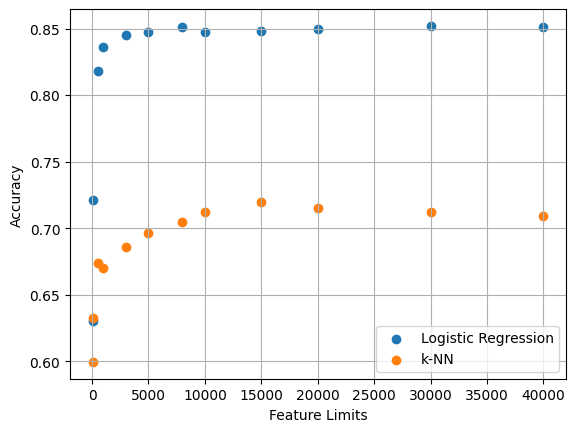

In [148]:
import matplotlib.pyplot as plt

feature_limits = [50, 100, 500, 1000, 3000, 5000, 8000, 10000, 15000, 20000, 30000, 40000]

log_accuracy = [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515, 0.8475, 0.8485, 0.85, 0.852, 0.851]
knn_accuracy = [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045, 0.7125, 0.7195, 0.715, 0.712, 0.7095]

log_accuracy = np.array(log_accuracy)
knn_accuracy = np.array(knn_accuracy)

#coefficients_log = np.polyfit(feature_limits, log_accuracy, deg=2)
#poly_function_log = np.poly1d(coefficients_log)

#coefficients_knn = np.polyfit(feature_limits, knn_accuracy, deg=2)
#poly_function_knn = np.poly1d(coefficients_knn)

# generating points for the curve
#x_curve = np.linspace(min(feature_limits), max(feature_limits), 100)
#y_curve_log = poly_function_log(x_curve)
#y_curve_knn = poly_function_knn(x_curve)

plt.scatter(feature_limits, log_accuracy, label='Logistic Regression')
plt.scatter(feature_limits, knn_accuracy, label='k-NN')

#plt.plot(x_curve, y_curve_log, label='log_accuracy', color='green')
#plt.plot(x_curve, y_curve_knn, label='log_accuracy', color='purple')

plt.xlabel('Feature Limits')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

**Saved Output Graph:**

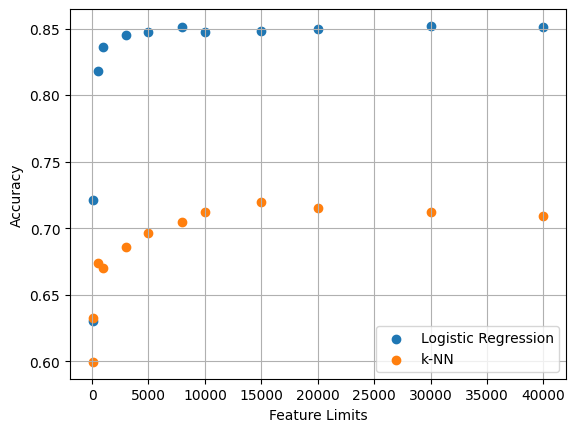

### Experiment Output Log

In [1]:
'''
Feature Limit: 50
Train Logistic Regression
Epoch [5/30], Loss: 0.6146, Training Accuracy: 0.6436
Epoch [10/30], Loss: 0.6339, Training Accuracy: 0.6525
Epoch [15/30], Loss: 0.6027, Training Accuracy: 0.6520
Epoch [20/30], Loss: 0.5664, Training Accuracy: 0.6549
Epoch [25/30], Loss: 0.7000, Training Accuracy: 0.6480
Epoch [30/30], Loss: 0.5521, Training Accuracy: 0.6542


Eval Loggistic Regression
---acc:  0.63
log_accuracy:  [0.63]


Fit knn
Eval knn
knn_accuracy:  [0.5995]


Feature Limit: 100
Train Logistic Regression
Epoch [5/30], Loss: 0.6093, Training Accuracy: 0.7153
Epoch [10/30], Loss: 0.4846, Training Accuracy: 0.7322
Epoch [15/30], Loss: 0.6263, Training Accuracy: 0.7364
Epoch [20/30], Loss: 0.5017, Training Accuracy: 0.7382
Epoch [25/30], Loss: 0.4175, Training Accuracy: 0.7384
Epoch [30/30], Loss: 0.5901, Training Accuracy: 0.7419


Eval Loggistic Regression
---acc:  0.7215
log_accuracy:  [0.63, 0.7215]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325]


Feature Limit: 500
Train Logistic Regression
Epoch [5/30], Loss: 0.4647, Training Accuracy: 0.7843
Epoch [10/30], Loss: 0.4077, Training Accuracy: 0.8096
Epoch [15/30], Loss: 0.4098, Training Accuracy: 0.8194
Epoch [20/30], Loss: 0.4276, Training Accuracy: 0.8255
Epoch [25/30], Loss: 0.3700, Training Accuracy: 0.8314
Epoch [30/30], Loss: 0.4259, Training Accuracy: 0.8343


Eval Loggistic Regression
---acc:  0.8185
log_accuracy:  [0.63, 0.7215, 0.8185]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674]


Feature Limit: 1000
Train Logistic Regression
Epoch [5/30], Loss: 0.4781, Training Accuracy: 0.7991
Epoch [10/30], Loss: 0.4350, Training Accuracy: 0.8253
Epoch [15/30], Loss: 0.3662, Training Accuracy: 0.8349
Epoch [20/30], Loss: 0.3486, Training Accuracy: 0.8474
Epoch [25/30], Loss: 0.3590, Training Accuracy: 0.8491
Epoch [30/30], Loss: 0.3999, Training Accuracy: 0.8584


Eval Loggistic Regression
---acc:  0.8365
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67]


Feature Limit: 3000
Train Logistic Regression
Epoch [5/30], Loss: 0.4822, Training Accuracy: 0.8037
Epoch [10/30], Loss: 0.4752, Training Accuracy: 0.8379
Epoch [15/30], Loss: 0.3249, Training Accuracy: 0.8520
Epoch [20/30], Loss: 0.4475, Training Accuracy: 0.8614
Epoch [25/30], Loss: 0.3566, Training Accuracy: 0.8662
Epoch [30/30], Loss: 0.4598, Training Accuracy: 0.8772


Eval Loggistic Regression
---acc:  0.845
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686]


Feature Limit: 5000
Train Logistic Regression
Epoch [5/30], Loss: 0.4196, Training Accuracy: 0.8106
Epoch [10/30], Loss: 0.4396, Training Accuracy: 0.8384
Epoch [15/30], Loss: 0.4159, Training Accuracy: 0.8520
Epoch [20/30], Loss: 0.3913, Training Accuracy: 0.8685
Epoch [25/30], Loss: 0.4164, Training Accuracy: 0.8775
Epoch [30/30], Loss: 0.3898, Training Accuracy: 0.8805


Eval Loggistic Regression
---acc:  0.8475
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965]


Feature Limit: 8000
Train Logistic Regression
Epoch [5/30], Loss: 0.5023, Training Accuracy: 0.8081
Epoch [10/30], Loss: 0.4017, Training Accuracy: 0.8403
Epoch [15/30], Loss: 0.4183, Training Accuracy: 0.8551
Epoch [20/30], Loss: 0.3023, Training Accuracy: 0.8704
Epoch [25/30], Loss: 0.3281, Training Accuracy: 0.8795
Epoch [30/30], Loss: 0.3119, Training Accuracy: 0.8859


Eval Loggistic Regression
---acc:  0.8515
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045]


Feature Limit: 10000
Train Logistic Regression
Epoch [5/30], Loss: 0.4867, Training Accuracy: 0.8096
Epoch [10/30], Loss: 0.4461, Training Accuracy: 0.8383
Epoch [15/30], Loss: 0.3146, Training Accuracy: 0.8570
Epoch [20/30], Loss: 0.2988, Training Accuracy: 0.8711
Epoch [25/30], Loss: 0.3374, Training Accuracy: 0.8808
Epoch [30/30], Loss: 0.3349, Training Accuracy: 0.8880


Eval Loggistic Regression
---acc:  0.8475
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515, 0.8475]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045, 0.7125]


Feature Limit: 15000
Train Logistic Regression
Epoch [5/30], Loss: 0.4563, Training Accuracy: 0.8090
Epoch [10/30], Loss: 0.3128, Training Accuracy: 0.8440
Epoch [15/30], Loss: 0.3821, Training Accuracy: 0.8608
Epoch [20/30], Loss: 0.3075, Training Accuracy: 0.8729
Epoch [25/30], Loss: 0.3467, Training Accuracy: 0.8812
Epoch [30/30], Loss: 0.2839, Training Accuracy: 0.8901


Eval Loggistic Regression
---acc:  0.8485
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515, 0.8475, 0.8485]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045, 0.7125, 0.7195]


Feature Limit: 20000
Train Logistic Regression
Epoch [5/30], Loss: 0.4811, Training Accuracy: 0.8097
Epoch [10/30], Loss: 0.4729, Training Accuracy: 0.8431
Epoch [15/30], Loss: 0.4474, Training Accuracy: 0.8602
Epoch [20/30], Loss: 0.3674, Training Accuracy: 0.8734
Epoch [25/30], Loss: 0.4233, Training Accuracy: 0.8802
Epoch [30/30], Loss: 0.2801, Training Accuracy: 0.8924


Eval Loggistic Regression
---acc:  0.85
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515, 0.8475, 0.8485, 0.85]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045, 0.7125, 0.7195, 0.715]


Feature Limit: 30000
Train Logistic Regression
Epoch [5/30], Loss: 0.4542, Training Accuracy: 0.8100
Epoch [10/30], Loss: 0.4298, Training Accuracy: 0.8472
Epoch [15/30], Loss: 0.3604, Training Accuracy: 0.8621
Epoch [20/30], Loss: 0.3281, Training Accuracy: 0.8718
Epoch [25/30], Loss: 0.3217, Training Accuracy: 0.8850
Epoch [30/30], Loss: 0.2328, Training Accuracy: 0.8922


Eval Loggistic Regression
---acc:  0.852
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515, 0.8475, 0.8485, 0.85, 0.852]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045, 0.7125, 0.7195, 0.715, 0.712]


Feature Limit: 40000
Train Logistic Regression
Epoch [5/30], Loss: 0.4453, Training Accuracy: 0.8116
Epoch [10/30], Loss: 0.3893, Training Accuracy: 0.8454
Epoch [15/30], Loss: 0.2755, Training Accuracy: 0.8644
Epoch [20/30], Loss: 0.3642, Training Accuracy: 0.8745
Epoch [25/30], Loss: 0.2550, Training Accuracy: 0.8856
Epoch [30/30], Loss: 0.2928, Training Accuracy: 0.8916


Eval Loggistic Regression
---acc:  0.851
log_accuracy:  [0.63, 0.7215, 0.8185, 0.8365, 0.845, 0.8475, 0.8515, 0.8475, 0.8485, 0.85, 0.852, 0.851]


Fit knn
Eval knn
knn_accuracy:  [0.5995, 0.6325, 0.674, 0.67, 0.686, 0.6965, 0.7045, 0.7125, 0.7195, 0.715, 0.712, 0.7095]
'''

'\nFeature Limit: 50\nTrain Logistic Regression\nEpoch [5/30], Loss: 0.6146, Training Accuracy: 0.6436\nEpoch [10/30], Loss: 0.6339, Training Accuracy: 0.6525\nEpoch [15/30], Loss: 0.6027, Training Accuracy: 0.6520\nEpoch [20/30], Loss: 0.5664, Training Accuracy: 0.6549\nEpoch [25/30], Loss: 0.7000, Training Accuracy: 0.6480\nEpoch [30/30], Loss: 0.5521, Training Accuracy: 0.6542\n\n\nEval Loggistic Regression\n---acc:  0.63\nlog_accuracy:  [0.63]\n\n\nFit knn\nEval knn\nknn_accuracy:  [0.5995]\n\n\nFeature Limit: 100\nTrain Logistic Regression\nEpoch [5/30], Loss: 0.6093, Training Accuracy: 0.7153\nEpoch [10/30], Loss: 0.4846, Training Accuracy: 0.7322\nEpoch [15/30], Loss: 0.6263, Training Accuracy: 0.7364\nEpoch [20/30], Loss: 0.5017, Training Accuracy: 0.7382\nEpoch [25/30], Loss: 0.4175, Training Accuracy: 0.7384\nEpoch [30/30], Loss: 0.5901, Training Accuracy: 0.7419\n\n\nEval Loggistic Regression\n---acc:  0.7215\nlog_accuracy:  [0.63, 0.7215]\n\n\nFit knn\nEval knn\nknn_accurac

#**Discussion**

* As depicted in the graphs, our expectations were met: the higher the dimensionality of the embedded data, the greater the accuracy of our models. A larger embedded space allows us to capture more information from the input, thereby enhancing the predictive capabilities of our models.

* We can also observe that the performance of logistic regression surpasses that of k-NN. We have already discussed this comparison extensively in the Methods section.

* However, the observation of most interest, which is directly related to our experimental inquiry, is that model accuracy tends to plateau after a certain number of features in our embedded space. This is most likely due to the fact that an excessive increase in features may introduce irrelevant information to the classification task. In other words,

* How does this experimental result affect us moving forward? Well, it gives us clues towards achieving an optimal dimensionality for our embedded space in terms of maximizing embedded information, as well as minimizing computation costs associated with high dimensionality. From the graphs, we can clearly see that this optimal dimensionality lies at the "inverse knee" of the graphs, located at the start of the accuracy plateau. This strategic dimensionality allows us to approach maximum model accuracy while minimizing the computational burden by utilizing the fewest features necessary.

# **References and Citations**
* [IMDB Moview Review Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

* General structure for the logistic regression training function: CMU 10-315 Intro to ML Recitation. [10-315 Recitation 7 Slides](https://docs.google.com/presentation/d/16b1ckL1CtJ5GVEiOM9--XwCr6wysJPcSYg33zZhVgPo/edit#slide=id.g157a7f534dc_0_12)

* Idea to save computational power when evaluating a model by using:  ```with torch.no_grad()``` [Pytorch Docs Source](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

* Tutorial on how CountVectorizer library works. [Source](https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c)

* Scikit-Learn Documentation on:
  - [Tf-Idf library ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

  - [Accuracy Score library](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
  - [KNeighborsClassifier library](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
  - [train_test_split library](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)